In [1]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = spark.read.option('header',True).option('sep',';').option('inferSchema',True).csv('/storage/business_zone/users/phongbd5/applied_ds/bank-full.csv')

In [3]:
df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|  5|  may|     19

In [4]:
num_cols = [_[0] for _ in df.dtypes if _[1] == 'int']
char_cols = [_[0] for _ in df.dtypes if _[1] == 'string']

In [5]:
indexers = [StringIndexer(inputCol = _, outputCol= _ + '_index' , handleInvalid = "keep") for _ in char_cols]

In [6]:
pipeline = Pipeline(stages=indexers)

In [7]:
df_transformed = pipeline.fit(df).transform(df).cache()

In [8]:
df_transformed = df_transformed.drop(*char_cols)

In [9]:
for _ in df_transformed.columns:
    if _.endswith('_index'):
        df_transformed = df_transformed.withColumnRenamed(_, _[0:-6])

In [10]:
df_transformed.show(10)

+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+---+
|age|balance|day|duration|campaign|pdays|previous| job|marital|education|default|housing|loan|contact|month|poutcome|  y|
+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+---+
| 58|   2143|  5|     261|       1|   -1|       0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|0.0|
| 44|     29|  5|     151|       1|   -1|       0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|0.0|
| 33|      2|  5|      76|       1|   -1|       0| 7.0|    0.0|      0.0|    0.0|    0.0| 1.0|    1.0|  0.0|     0.0|0.0|
| 47|   1506|  5|      92|       1|   -1|       0| 0.0|    0.0|      3.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|0.0|
| 33|      1|  5|     198|       1|   -1|       0|11.0|    1.0|      3.0|    0.0|    1.0| 0.0|    1.0|  0.0|     0.0|0.0|
| 35|    231|  5|     13

In [11]:
assembler = VectorAssembler(inputCols = df_transformed.columns[0:-1], outputCol = 'features')

In [12]:
assembler

VectorAssembler_431c80a5a6a37dc9e881

In [13]:
assembled_df = assembler.transform(df_transformed)

In [14]:
assembled_df = assembled_df.withColumnRenamed('y', 'label')

In [15]:
assembled_df = assembled_df.withColumn('label', col('label').cast(IntegerType()))

### Simple Random Sampling

In [16]:
train, test = df.randomSplit([0.7, 0.3], seed = 12345) # Random Split

In [17]:
train.count(), test.count()

(31457, 13754)

### Tuning with Validation

In [18]:
# Model initialization
lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label', family = 'binomial')

In [19]:
# Model parameters to try
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

In [20]:
# 70% of the data will be used for training, 30% for validation.
train_valid_clf = TrainValidationSplit(estimator = lr,
estimatorParamMaps = paramGrid, evaluator = BinaryClassificationEvaluator(),
trainRatio = 0.7)

In [21]:
train_valid_clf_model = train_valid_clf.fit(assembled_df)

In [22]:
train_valid_clf_model.transform(assembled_df).show(2,False)

+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+-----+----------------------------------------------------------------------+--------------------------------------+-----------------------------------------+----------+
|age|balance|day|duration|campaign|pdays|previous|job|marital|education|default|housing|loan|contact|month|poutcome|label|features                                                              |rawPrediction                         |probability                              |prediction|
+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+-----+----------------------------------------------------------------------+--------------------------------------+-----------------------------------------+----------+
|58 |2143   |5  |261     |1       |-1   |0       |1.0|0.0    |1.0      |0.0    |0.0    |0.0 |1.0    |0.0  |0.0     |0    |(16,[0,1,2,3,4,5,7,9

### Stratified Sampling

In [23]:
# split data for 0s and 1s
zero_df = assembled_df.filter(assembled_df["label"]==0)
one_df = assembled_df.filter(assembled_df["label"]==1)

In [24]:
# split data into train and test
train_zero, test_zero = zero_df.randomSplit([0.7,0.3], seed = 12345)
train_one, test_one = one_df.randomSplit([0.7,0.3], seed = 12345)

In [25]:
# union datasets
train = train_zero.union(train_one)
test = test_zero.union(test_one)

### Holdout/Out of time

In [26]:
train, test, holdout = assembled_df.randomSplit([0.7, 0.2, 0.1], seed=12345)

### k-fold Cross-Validation

In [27]:
#model initialization
lr = LogisticRegression(maxIter=10, featuresCol='features',
labelCol='label', family = 'binomial')

In [28]:
#model parameters to try
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

In [29]:
# 3 folds
crossval_clf = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
evaluator=BinaryClassificationEvaluator(), numFolds = 5)

In [30]:
# assembled_df is the output of the vector assembler
model = crossval_clf.fit(assembled_df)

In [111]:
pred_results = model.transform(assembled_df)

In [112]:
pred_results.show(2)

+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+-----+--------------------+--------------------+--------------------+----------+
|age|balance|day|duration|campaign|pdays|previous|job|marital|education|default|housing|loan|contact|month|poutcome|label|            features|       rawPrediction|         probability|prediction|
+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+-----+--------------------+--------------------+--------------------+----------+
| 58|   2143|  5|     261|       1|   -1|       0|1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|    0|(16,[0,1,2,3,4,5,...|[3.24245233965241...|[0.96240094898666...|       0.0|
| 44|     29|  5|     151|       1|   -1|       0|2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|    0|(16,[0,1,2,3,4,5,...|[3.49906403468531...|[0.97066112646973...|       0.0|
+---+-------+--

In [32]:
model.avgMetrics

[0.8892808109681581,
 0.8520170101260824,
 0.8075649012214815,
 0.8895074674991232,
 0.8788648984347307,
 0.8784900671726182]

In [33]:
model.bestModel.summary.accuracy

0.8984539160823694

In [34]:
evaluator = BinaryClassificationEvaluator()

In [35]:
evaluator.evaluate(model.transform(assembled_df))

0.8901741028774239

## Continuous Target Evaluation

In [36]:
cSchema = StructType([StructField("x1", IntegerType())\
                    ,StructField("x2", IntegerType())\
                    ,StructField("y", IntegerType())])

df_list = [[58, 50, 12], [37, 95, 27], [29, 137, 39], [19, 150, 45]]

In [37]:
df = spark.createDataFrame(df_list, schema=cSchema)

In [38]:
df.show()

+---+---+---+
| x1| x2|  y|
+---+---+---+
| 58| 50| 12|
| 37| 95| 27|
| 29|137| 39|
| 19|150| 45|
+---+---+---+



In [39]:
df.columns

['x1', 'x2', 'y']

In [40]:
assembler = VectorAssembler(inputCols = df.columns[0:-1], outputCol='features')

In [41]:
df = assembler.transform(df)

In [42]:
df.show(10)

+---+---+---+------------+
| x1| x2|  y|    features|
+---+---+---+------------+
| 58| 50| 12| [58.0,50.0]|
| 37| 95| 27| [37.0,95.0]|
| 29|137| 39|[29.0,137.0]|
| 19|150| 45|[19.0,150.0]|
+---+---+---+------------+



In [43]:
reg = LinearRegression(featuresCol='features', labelCol='y')

In [44]:
reg_model = reg.fit(df) # fit model

In [45]:
print(reg_model.coefficients, reg_model.intercept)

[-0.22711168360076145,0.23997908536603502] 12.95150146919544


In [46]:
pred_result = reg_model.transform(assembled_df)

In [47]:
reg_summary = reg_model.summary

In [48]:
#R-Squared, MSE, RMSE, MAE, Explained Variance (Var)
reg_summary.r2 , reg_summary.meanSquaredError, reg_summary.rootMeanSquaredError, reg_summary.meanAbsoluteError, reg_summary.explainedVariance

(0.9994306366573976,
 0.09063552710051803,
 0.3010573485243601,
 0.29438981283037435,
 159.09686447289982)

## Binary Target Evaluation

In [107]:
predictionAndTarget = pred_result.select("prediction", "label")
predictionAndTarget = predictionAndTarget.withColumn("label", predictionAndTarget["label"].cast(DoubleType()))
predictionAndTarget = predictionAndTarget.withColumn("prediction", predictionAndTarget["prediction"].cast(DoubleType()))
metrics = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

In [108]:
cm = metrics.confusionMatrix().toArray()

In [109]:
cm

array([[39174.,   748.],
       [ 3843.,  1446.]])

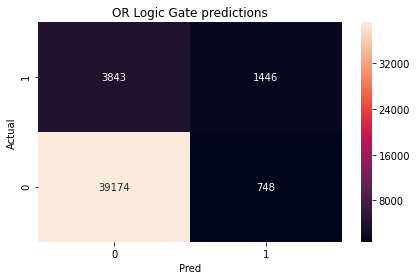

In [110]:
def make_confusion_matrix_chart(cf_matrix):
    list_values = ['0', '1']
    plt.subplot(111)
    sns.heatmap(cf_matrix, annot=True, yticklabels=list_values, xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('OR Logic Gate predictions')
    plt.tight_layout()
    return None

make_confusion_matrix_chart(cm) #make confusion matrix plot

In [116]:
#Accuracy
acc = metrics.accuracy

#Misclassification rate
misclassification_rate = 1 - acc

#Precision
precision = metrics.precision(1.0)

#Recall
recall = metrics.recall(1.0)

#F1 Score
f1 = metrics.fMeasure(1.0)

#ROC
evaluator = BinaryClassificationEvaluator(labelCol = 'label', rawPredictionCol = 'rawPrediction', metricName = 'areaUnderROC')
roc = evaluator.evaluate(pred_result)

print(acc, misclassification_rate, precision, recall, f1, roc)

0.8984539160823694 0.10154608391763065 0.659070191431176 0.2733976176971072 0.38647601229453427 0.8901741028774237


In [119]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)
        
    def _to_list(self, rdd):
        points = []
        results_collect = rdd.collect()
        for row in results_collect:
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [124]:
# use the probability colum to apply cut-offs
preds = pred_result.select('label','probability').rdd.map(lambda row:(float(row['probability'][1]), float(row['label'])))

In [125]:
points = CurveMetrics(preds).get_curve('roc')

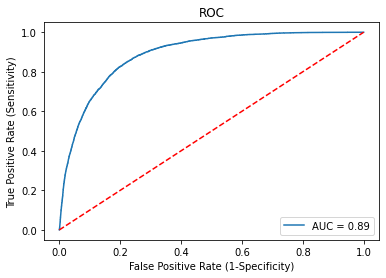

In [126]:
import matplotlib.pyplot as plt
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(x_val, y_val, label = 'AUC = %0.2f' % roc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.legend(loc = 'lower right')

In [128]:
evaluator = BinaryClassificationEvaluator(labelCol = 'label', rawPredictionCol = 'rawPrediction', metricName = 'areaUnderPR')

pr = evaluator.evaluate(pred_result)
preds = pred_result.select('label','probability').rdd.map(lambda row:(float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('pr')

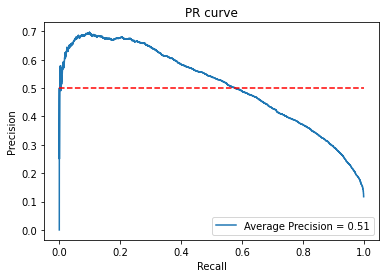

In [129]:
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val, label = 'Average Precision = %0.2f' % pr)
plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--')
plt.legend(loc = 'lower right')